# Analysis of normalizing flow results on VAE latent space

In [2]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [21]:
import torch
from pathlib import Path

from torchvision.utils import make_grid
import matplotlib.pyplot as plt
import lightning as pl
import normflows as nf
import numpy as np
from torch.utils.data import DataLoader
from torchvision import transforms
from ciflows.datasets.causalceleba import CausalCelebA
from ciflows.distributions.pgm import LinearGaussianDag

from ciflows.eval import load_model
from ciflows.flows.model import CausalNormalizingFlow
from ciflows.reduction.vae import VAE


In [5]:
def make_nf_model(debug=False):
    """Make normalizing flow model."""
    # Define list of flows
    if debug:
        K = 2
        net_hidden_layers = 2
        net_hidden_dim = 64
    else:
        K = 8
        net_hidden_layers = 3
        net_hidden_dim = 64

    latent_dim = 48

    flows = []
    for i in range(K):
        flows += [
            nf.flows.AutoregressiveRationalQuadraticSpline(
                latent_dim, net_hidden_layers, net_hidden_dim
            )
        ]

    node_dimensions = {
        0: 16,
        1: 16,
        2: 16,
    }
    edge_list = [(1, 2)]
    noise_means = {
        0: torch.zeros(16),
        1: torch.zeros(16),
        2: torch.zeros(16),
    }
    noise_variances = {
        0: torch.ones(16),
        1: torch.ones(16),
        2: torch.ones(16),
    }
    intervened_node_means = [{2: torch.ones(16) + 2}, {2: torch.ones(16) + 4}]
    intervened_node_vars = [{2: torch.ones(16)}, {2: torch.ones(16) + 2}]

    confounded_list = []
    # independent noise with causal prior
    q0 = LinearGaussianDag(
        node_dimensions=node_dimensions,
        edge_list=edge_list,
        noise_means=noise_means,
        noise_variances=noise_variances,
        confounded_list=confounded_list,
        intervened_node_means=intervened_node_means,
        intervened_node_vars=intervened_node_vars,
    )

    # Construct flow model with the multiscale architecture
    model = CausalNormalizingFlow(q0, flows)
    return model


In [6]:
seed = 12345

# set seed
np.random.seed(seed)
pl.seed_everything(seed, workers=True)

if torch.cuda.is_available():
    device = torch.device("cuda")
    accelerator = "cuda"
elif torch.backends.mps.is_available():
    device = torch.device("mps")
    accelerator = "mps"
else:
    device = torch.device("cpu")
    accelerator = "cpu"

print(f"Using device: {device}")
print(f"Using accelerator: {accelerator}")

Seed set to 12345


Using device: mps
Using accelerator: mps


In [60]:
root = Path("/Users/adam2392/pytorch_data/")
graph_type = 'chain'
# v1: K=32
# v2: K=8
# v3: K=8, batch higher
model_fname = "celeba_nfonvaereduction_batch1024_latentdim48_v2.pt"

# checkpoint_dir = root / "CausalCelebA" / "vae_reduction" / "latentdim24"
checkpoint_dir = (
    root / "CausalCelebA" / "nf_on_vae_reduction" / model_fname.split(".")[0]
)
checkpoint_dir.mkdir(parents=True, exist_ok=True)

vae_dir = root / "CausalCelebA" / "vae_reduction" / "latentdim48"
vae_model_fname = "model_epoch_2840.pt"
vae_model = VAE().to(device)
model_path = vae_dir / vae_model_fname
vae_model = load_model(vae_model, model_path, device)

Model loaded from /Users/adam2392/pytorch_data/CausalCelebA/vae_reduction/latentdim48/model_epoch_2840.pt


/Users/adam2392/Documents/ciflows/ciflows/eval.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(model_path, map_location=device)


In [31]:

# load the normalizing flow model
nf_model = make_nf_model().to(device)
# nf_model = torch.compile(nf_model)
model_path = checkpoint_dir / 'model_epoch_170.pt'
# nf_model = load_model(nf_model, model_path, device)
state_dict = torch.load(model_path, map_location=device)
print(state_dict.keys())
new_state_dict = {k.replace('_orig_mod.', ''): v for k, v in state_dict.items()}
nf_model.load_state_dict(new_state_dict)

odict_keys(['_orig_mod.q0.exog_mean_0_0', '_orig_mod.q0.exog_variance_0_0', '_orig_mod.q0.exog_mean_1_0', '_orig_mod.q0.exog_variance_1_0', '_orig_mod.q0.exog_mean_2_0', '_orig_mod.q0.exog_variance_2_0', '_orig_mod.q0.exog_mean_2_1', '_orig_mod.q0.exog_variance_2_1', '_orig_mod.q0.exog_mean_2_2', '_orig_mod.q0.exog_variance_2_2', '_orig_mod.q0.edge_weights.1->2', '_orig_mod.flows.0.mprqat.autoregressive_net.initial_layer.weight', '_orig_mod.flows.0.mprqat.autoregressive_net.initial_layer.bias', '_orig_mod.flows.0.mprqat.autoregressive_net.initial_layer.mask', '_orig_mod.flows.0.mprqat.autoregressive_net.initial_layer.degrees', '_orig_mod.flows.0.mprqat.autoregressive_net.blocks.0.linear_layers.0.weight', '_orig_mod.flows.0.mprqat.autoregressive_net.blocks.0.linear_layers.0.bias', '_orig_mod.flows.0.mprqat.autoregressive_net.blocks.0.linear_layers.0.mask', '_orig_mod.flows.0.mprqat.autoregressive_net.blocks.0.linear_layers.0.degrees', '_orig_mod.flows.0.mprqat.autoregressive_net.blocks.

/Users/adam2392/Documents/ciflows/ciflows/distributions/pgm.py:101: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  f"exog_mean_{node}_0", torch.tensor(noise_means.get(node, 0.0))
/Users/adam2392/Documents/ciflows/ciflows/distributions/pgm.py:104: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  f"exog_variance_{node}_0", torch.tensor(noise_variances.get(node, 1.0))
/Users/adam2392/Documents/ciflows/ciflows/distributions/pgm.py:143: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(mean),
/Users/adam2392/Documents/ciflows/ciflows/dist

<All keys matched successfully>

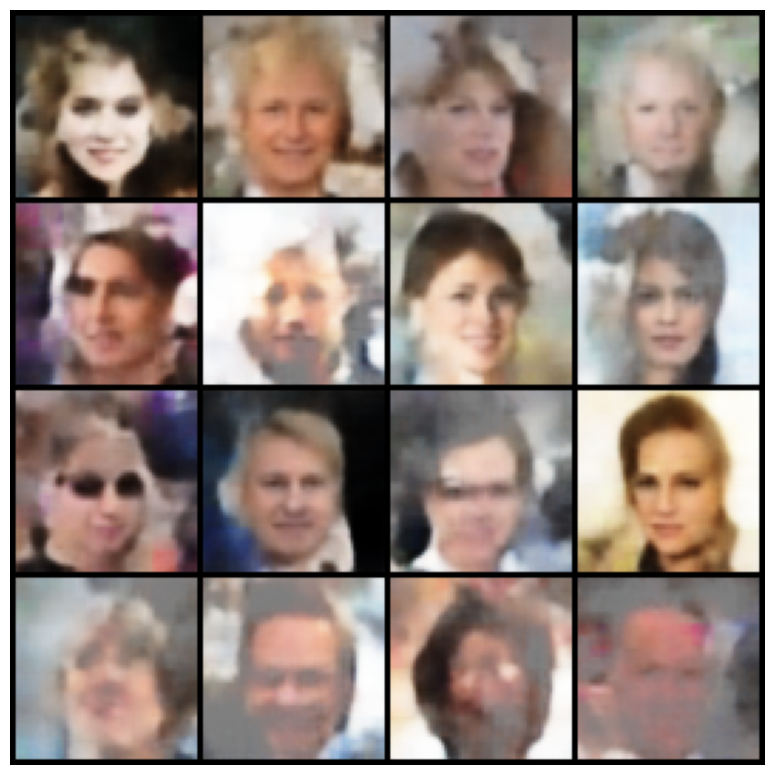

In [61]:
# sample from VAE model
vae_model.eval()

n_samples = 16
IMAGE_SIZE = 64

# Sample random latent vectors from a standard normal distribution
z = torch.randn(n_samples, 48).to(device)

# Decode these latent vectors using the decoder part of the VAE
samples = vae_model.decode(z)

# Rescale samples to [0, 1] range for visualization (if necessary)
samples = samples.view(-1, 3, IMAGE_SIZE, IMAGE_SIZE)

# Create a 4x4 grid for displaying images
grid = make_grid(samples, nrow=4, padding=2, normalize=True)

# Convert tensor to numpy and transpose to (H, W, C) format for visualization
grid = grid.permute(1, 2, 0).cpu().numpy()

# Plot the grid
plt.figure(figsize=(8, 8))
plt.imshow(grid)
plt.axis('off')  # Hide axes
plt.show()

In [ ]:
# load in real images, embed, and then perturb and decode
image_transform = transforms.Compose(
    [
        transforms.Resize((64, 64), antialias=True),  # Resize images to 128x128
        transforms.CenterCrop(64),  # Ensure square crop
        transforms.ToTensor(),  # Convert images to PyTorch tensors
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ]
)
causal_celeba_dataset = CausalCelebA(
    root=root,
    graph_type=graph_type,
    transform=image_transform,
    fast_dev_run=False,  # Set to True for debugging
)

# Define the DataLoader
dataloader = DataLoader(
    dataset=causal_celeba_dataset,
    batch_size=n_samples,
    drop_last=True,
    shuffle=True,  # Shuffle data during training
    num_workers=2,
    pin_memory=True,  # Enable if using a GPU
)


Processing intervention type: Haircolor


In [55]:
print(len(causal_celeba_dataset))
# load a batch of images
images, _, _ = next(iter(dataloader))

print(images.shape)

90000
torch.Size([16, 3, 64, 64])


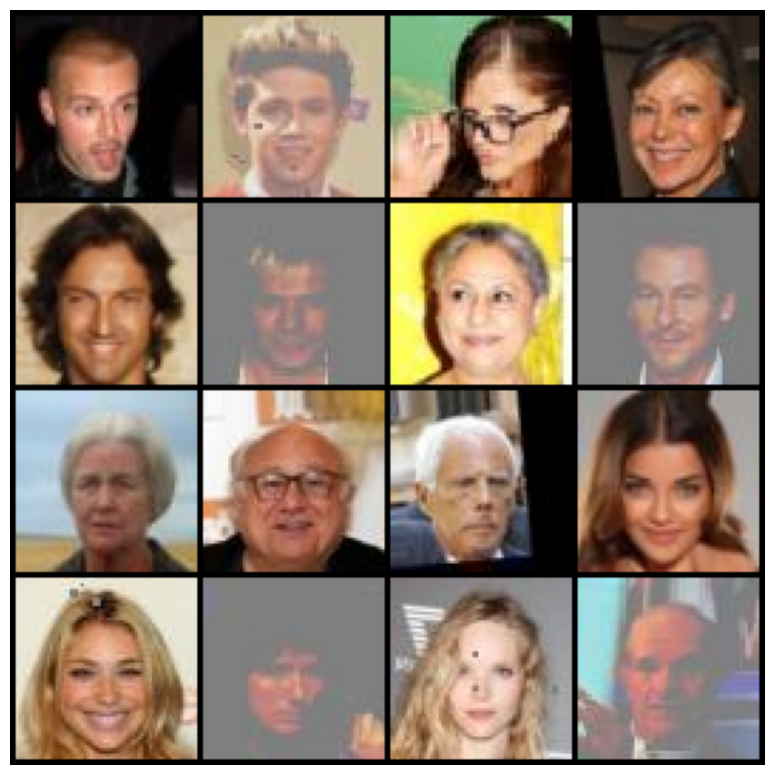

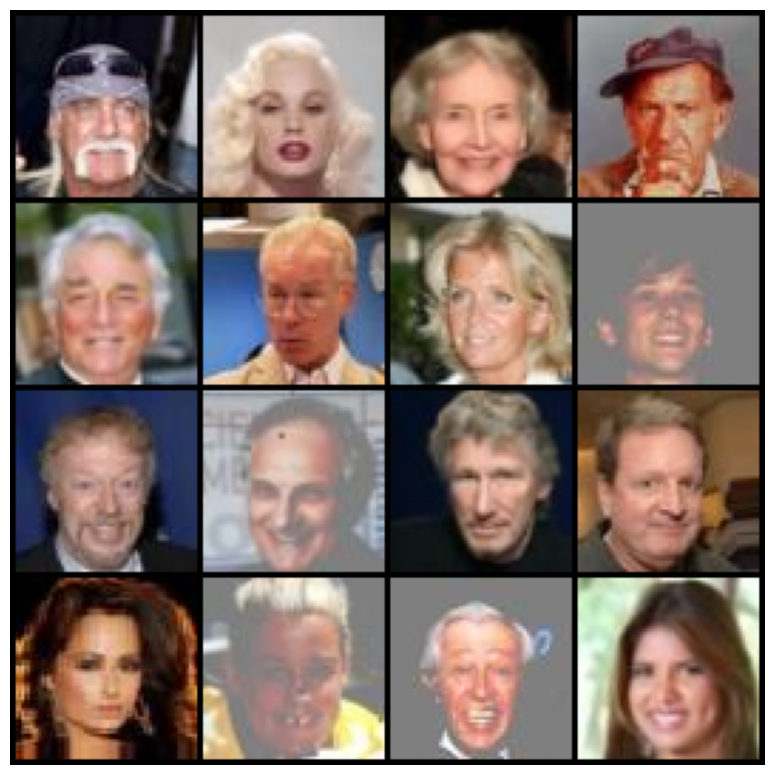

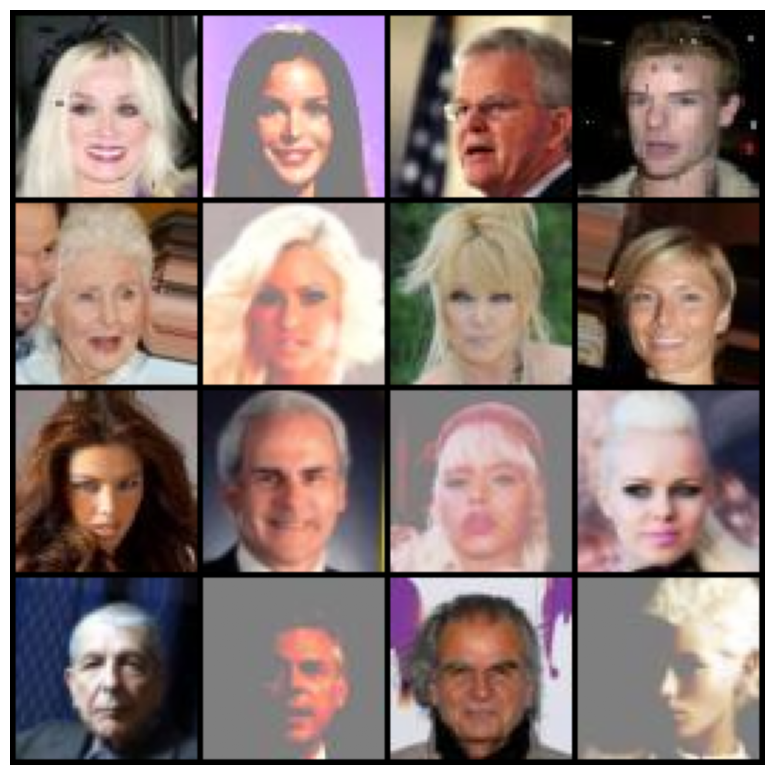

In [56]:
for batch_idx, (images, meta_labels, targets) in enumerate(dataloader):
    images = images.to(device)
    # Create a 4x4 grid for displaying images
    grid = make_grid(images, nrow=4, padding=2, normalize=True)

    # Convert tensor to numpy and transpose to (H, W, C) format for visualization
    grid = grid.permute(1, 2, 0).cpu().numpy()

    # Plot the grid
    plt.figure(figsize=(8, 8))
    plt.imshow(grid)
    plt.axis('off')  # Hide axes
    plt.show()

    if batch_idx == 2:
        break

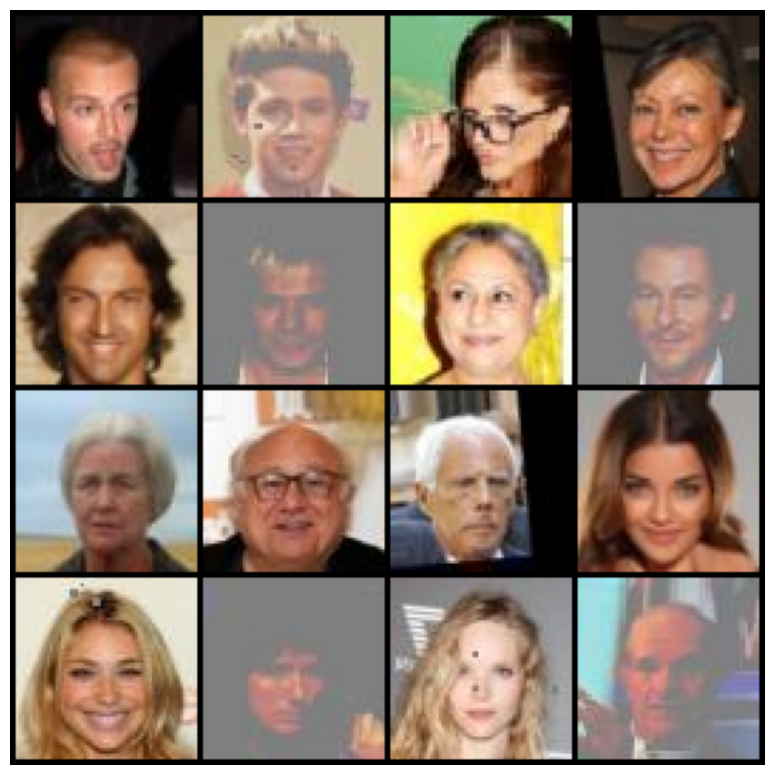

In [54]:
# Create a 4x4 grid for displaying images
grid = make_grid(images, nrow=4, padding=2, normalize=True)

# Convert tensor to numpy and transpose to (H, W, C) format for visualization
grid = grid.permute(1, 2, 0).cpu().numpy()

# Plot the grid
plt.figure(figsize=(8, 8))
plt.imshow(grid)
plt.axis('off')  # Hide axes
plt.show()

In [65]:
# perturb the image representations
images = images.to(device)

# Encode the images using the encoder part of the VAE
mu, log_var = vae_model.encode(images)

latent_vector = vae_model.reparameterize(mu, log_var)

# pass latent vector through normalizing flow
vhat_latent = nf_model.inverse(latent_vector)

# perturb last 16 dimensions -> hair color
vhat_latent[:, 32:] += torch.rand(n_samples, 16).to(device)

# reconstruct the perturbed latent vector
print(vhat_latent.shape)
perturbed_latent_vector = nf_model.forward(vhat_latent)

# pass through decoder
perturbed_images = vae_model.decode(perturbed_latent_vector)
print(nf_model.q0.node_dimensions)
print(latent_vector.shape, vhat_latent.shape)

torch.Size([16, 48])
{0: 16, 1: 16, 2: 16}
torch.Size([16, 48]) torch.Size([16, 48])


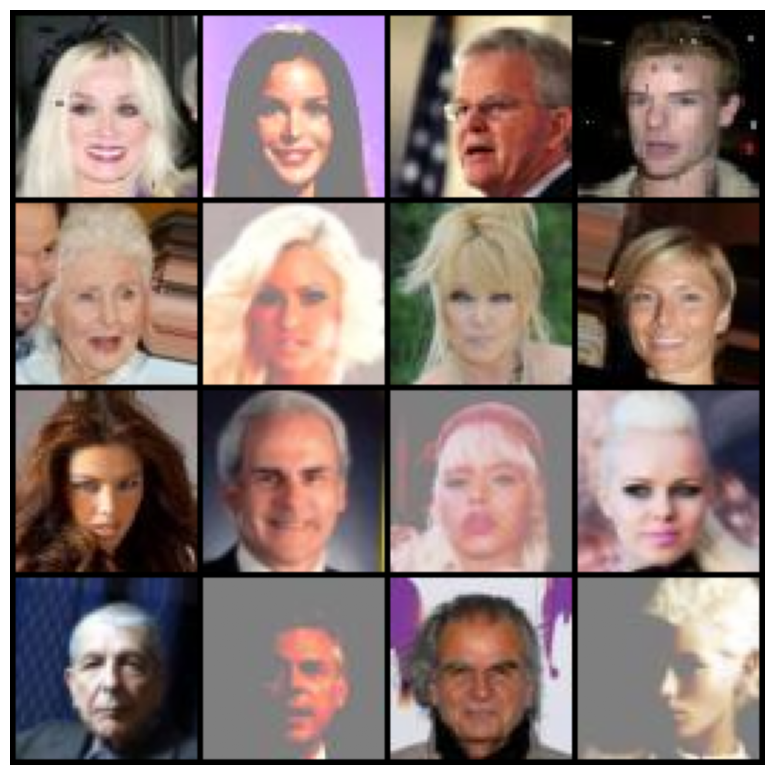

In [66]:
# Create a 4x4 grid for displaying images
grid = make_grid(images, nrow=4, padding=2, normalize=True)

# Convert tensor to numpy and transpose to (H, W, C) format for visualization
grid = grid.permute(1, 2, 0).cpu().numpy()

# Plot the grid
plt.figure(figsize=(8, 8))
plt.imshow(grid)
plt.axis('off')  # Hide axes
plt.show()

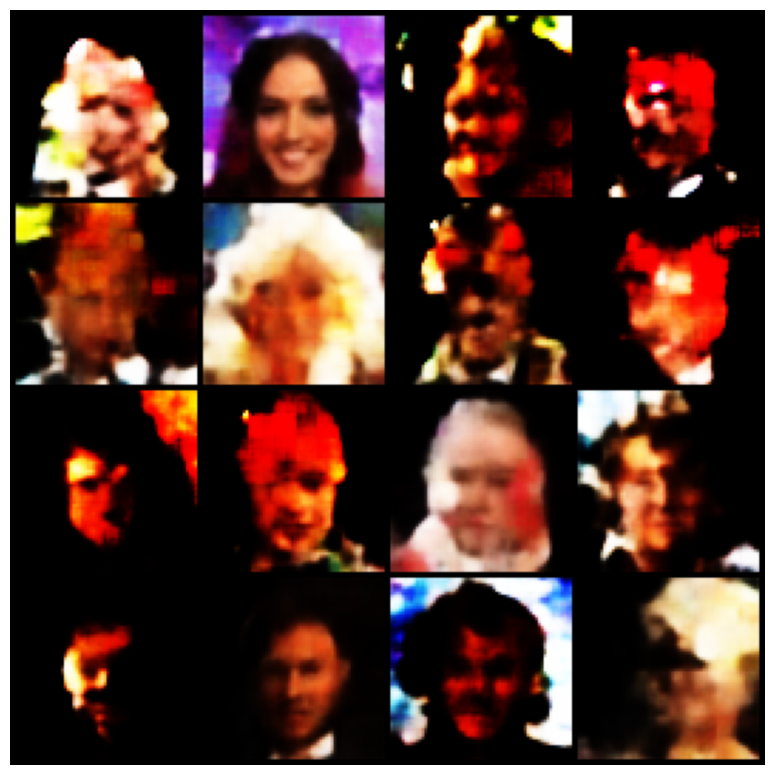

In [67]:
perturbed_images = perturbed_images.view(-1, 3, IMAGE_SIZE, IMAGE_SIZE)
# Create a 4x4 grid for displaying images
grid = make_grid(perturbed_images, nrow=4, padding=2, normalize=True)

# Convert tensor to numpy and transpose to (H, W, C) format for visualization
grid = grid.permute(1, 2, 0).cpu().numpy()

# Plot the grid
plt.figure(figsize=(8, 8))
plt.imshow(grid)
plt.axis('off')  # Hide axes
plt.show()